# Project: Pizza Classification and Ingredient Recognition

## Context
This project utilizes Kaggle datasets and Python notebooks running on GPUs to train two distinct models:
1. An image classification model to detect the presence of a pizza.
2. A model to identify the ingredients of a pizza.

The final objective is to integrate these two models to build an application capable of retrieving a pizza image, identifying if it’s a pizza, and listing the main ingredients.

---

## Project Steps

### 1. Retrieving the "Pizza or Not Pizza" Dataset
- **Objective**: Download the "Pizza or Not Pizza" dataset from Kaggle for training the first model.
- **Steps**:
  - Import the dataset via the Kaggle API.
  - Prepare images for training (preprocessing, resizing).

### 2. Training and Optimization of the "Pizza or Not Pizza" Model
- **Objective**: Train a classification model to detect whether an image contains a pizza.
- **Steps**:
  - Define the model architecture (e.g., CNN).
  - Use GPUs to accelerate training.
  - Optimize hyperparameters (e.g., learning rate, number of epochs).

### 3. Model Evaluation and Visualization Tool
- **Objective**: Evaluate the model's performance and visualize some example predictions.
- **Steps**:
  - Calculate performance metrics (precision, recall, F1-score).
  - Use a notebook to visualize examples of correct and incorrect predictions.

### 4. Retrieving the "Pizza Ingredients" Dataset
- **Objective**: Download the pizza ingredients dataset for training the second model.
- **Steps**:
  - Import the dataset via Kaggle.
  - Process the data to make it compatible with the ingredient identification model.
  

### 5. Training and Optimization of the "Pizza Ingredients" Model
- **Objective**: Train a model to recognize ingredients in pizza images.
- **Steps**:
  - Design the model for ingredient identification. In step 4, we now have imported the dataset with labels, and we then have to build the technology to put the localization boxes on these images. In that way, we have the possibilty to measure the quality of the output of the model during training, by minimizing the distance between both reality and prediction, and the value of the label.
  - Optimize training using GPUs on Kaggle.
  - Adjust hyperparameters to improve prediction accuracy.

### 6. Test and Visualization of Ingredient Predictions
- **Objective**: Test the ingredient model and visualize the predictions.
- **Steps**:
  - **Evaluation**: Calculate performance metrics such as precision, recall, and F1-score.
  - **Prediction Visualization**: Implement an algorithm to take an image as input and return it with labeled or segmented ingredients.
    - **Algorithm**:
      1. Load the trained ingredient model.
      2. Preprocess the input image (resize, normalize, etc.).
      3. Apply the model to predict ingredients.
      4. Create a segmentation map based on predicted ingredients.
      5. Overlay the segmentation map on the original image.
      6. Return the labeled image.
  - **Example Visualization**: Display an example image with ingredient labels.

### 7. Integration of Both Models
- **Objective**: Integrate the "Pizza or Not Pizza" and "Pizza Ingredients" models for a comprehensive classification.
- **Steps**:
  - Create a function that first applies the pizza detection model, followed by the ingredient model.
  - Handle cases where the image does not contain a pizza (detected as "not pizza").

### 8. Building a Complete Example
- **Objective**: Set up an end-to-end workflow for pizza and ingredient recognition.
- **Steps**:
  - Create a function to retrieve a pizza image (from a URL or by upload).
  - Pass the image through the model pipeline to detect pizza and list ingredients.
  - Present the final result in a notebook, with visualizations of the intermediate steps.

---

## Technologies and Tools
- **Language**: Python
- **Frameworks**: TensorFlow or PyTorch
- **Execution Environment**: Kaggle Notebooks with GPU support
- **Visualization**: Matplotlib, Seaborn for results display
- **Dataset Access**: Kaggle API

---

## Deliverables
- **Kaggle Notebooks**: Containing each step of the process.
- **Trained Models**: Exported model files for pizza detection and ingredient identification.
- **Documentation**: Explanation of each step and results.

---

This project will provide hands-on experience in training image classification models and integrating them into a complete image analysis pipeline.


# Utilities for Processing the "Pizza Toppings" Object Detection Dataset

This notebook defines and uses a set of utility functions to streamline the loading, conversion, and visualization of data for object detection. These functions are designed to efficiently prepare images and annotations from the **Pizza Toppings Object Detection** dataset, simplifying the workflow for training an object detection model with Keras and TensorFlow. Below is an overview of the primary utilities:

### Utility Functions

1. **`load_imgs(path, no_of_images, img_size, do_display)`**  
   This function loads a specified number of images from a folder, resizes each image, and optionally displays them. It returns a dictionary of images and a list of their paths, standardizing image sizes for use in a deep learning model.

2. **`convert_bbox(coordinates, image_width, image_height)`**  
   This function converts bounding box coordinates from the YOLOv8 format (center coordinates and relative width/height) to a more conventional format (top-left and bottom-right corners). This conversion is essential for visualizing annotations on images and ensuring compatibility with libraries like PIL or OpenCV.

3. **`load_annotations(path, labels, no_of_annotations, do_display)`**  
   This function loads annotations from text files and associates them with the dataset’s label definitions. It processes and converts coordinates, returning a dictionary of annotations for each image. This utility links each image with its bounding box information, simplifying data preparation for model training.

4. **`plot_image_annotations(image_paths, annotations, label_colors, target_size, do_display, text_display, font_scale, alpha)`**  
   This function displays images with their annotations by drawing bounding boxes around detected objects. It uses predefined colors for each label and offers customization options like text scaling and box transparency. This utility is key for visually inspecting the annotated data and ensuring data quality before training.
   
5. **`plot_model_evaluation(history)`**
    This function visualizes the performance of a model by plotting training and validation losses for bounding box and classification outputs. It helps in understanding model convergence and monitoring overfitting or underfitting trends over epochs.


These utilities provide a structured way to load, process, and handle images and annotations, making the data workflow efficient and consistent for object detection model training.


In [1]:
import os
import cv2
from matplotlib import pyplot as plt
import matplotlib.patches as patches
from PIL import Image, ImageDraw, ImageFont
import numpy as np
import matplotlib.pyplot as plt
from keras.callbacks import History
from typing import Dict, List, Tuple

# Global Variables

INPUT_SHAPE: Tuple[int, int, int] = (512, 512, 3)
IMG_SIZE: Tuple[int, int] = (512, 512)
SAVE_MODEL: bool = True

def log_debug_template(msg: str = "Cell executed") -> None:
    print("-" * 100)
    print("")
    print(" " * 40 + msg)
    print("")
    print("-" * 100)

def load_imgs(path: str, no_of_images: int, img_size: Tuple[int, int] = IMG_SIZE, do_display: bool = False) -> Tuple[Dict[int, Image.Image], List[str]]:
    """Function which loads images from the given path

    Args:
        path (str): path to the folder with images.
        no_of_images (int): number of images to load.
        img_size (tuple, optional): size of the image. Defaults to IMG_SIZE.
        do_display (bool): flag to display images. Defaults to False.

    Returns:
        images (dict): dictionary with images
        image_paths (list): list of image paths
    """
    # Declaring necessary variables
    images = {}
    image_paths = []

    # Iterating through all images in the given path
    for img_no, img_name in enumerate(os.listdir(path)):
        # Breaking from loop if no_of_images is reached
        if img_no == no_of_images:
            break

        # Loading, resizing and storing images in a dictionary
        image_paths.append(os.path.join(path, img_name))
        img = Image.open(os.path.join(path, img_name))
        img = img.resize(img_size)
        images[img_no] = img

        # Displaying images if do_display is True
        if do_display:
            print('\033[1m' + 'Image {}  Image name: {}'.format(img_no+1, img_name) + '\033[0m')
            display(img)
    
    # Returning images and image paths
    return images, image_paths


def load_annotations(path: str, labels: Dict[int, str], no_of_annotations: int, do_display: bool = False) -> Dict[str, List[Dict[str, List[float]]]]:
    """Function which loads annotations from the given path

    Args:
        path (str): path to the folder with annotations.
        labels (dict): dictionary with labels and their corresponding string names.
        no_of_annotations (int): number of annotations to load.
        do_display (bool): flag to display annotations. Defaults to False.

    Returns:
        annotations (dict): dictionary with annotations.
    """
    # Declaring necessary variables
    annotations = {}

    # Iterating over all files in the directory
    for filename in os.listdir(path):
        # Breaking from loop if no_of_annotations is reached
        if len(annotations) == no_of_annotations:
            break

        # Displaying filename if do_display is True
        if do_display:
            print('\033[35m' + 'Filename: {}'.format(filename) + '\033[0m')

        # Constructing the full file path
        file_path = os.path.join(path, filename)

        # Removing the final file extension from the filename
        filename = filename.rsplit('.', 1)[0]
        
        # Declaring empty list for the current filename
        annotations[filename] = []

        # Opening the file and reading its contents
        with open(file_path, 'r') as file:
        # Iterating through each line in the file
            for line in file:
                # Splitting the line into label and coordinates
                parts = line.strip().split(' ')
                label = labels[int(parts[0])]
                coordinates = [float(coord) for coord in parts[1:]]

                # Storing the data in the dictionary
                annotations[filename].append({label: coordinates})

                # Displaying annotations if do_display is True
                if do_display:
                    print('\033[33m' + 'Label:' + '\033[0m' + ' {}'.format(label) + '\033[32m' + ' Coordinates:' + '\033[0m' + ' {}'.format(coordinates))
        
        if do_display:
            print()

    # Returning annotations
    return annotations

def convert_bbox(coordinates: List[float], image_width: int, image_height: int) -> List[int]:
    """Function to convert bounding box coordinates from YOLOv8 format to PIL format

    Args:
        coordinates (list): list of bounding box coordinates in YOLOv8 format [x_center, y_center, width, height]
        image_width (int): width of the original image
        image_height (int): height of the original image

    Returns:
        new_coordinates (list): list of bounding box coordinates in PIL format [x1, y1, x2, y2]
    """
    # Unpacking coordinates from YOLOv8 format
    x_center, y_center, width, height = coordinates

    # Calculating new width and height
    new_width = width * image_width
    new_height = height * image_height

    # Calculating new center
    new_x_center = x_center * image_width
    new_y_center = y_center * image_height

    # Calculating new coordinates
    new_x1 = int(new_x_center - (new_width / 2))
    new_y1 = int(new_y_center - (new_height / 2))
    new_x2 = int(new_x_center + (new_width / 2))
    new_y2 = int(new_y_center + (new_height / 2))

    # Returning new coordinates
    return [new_x1, new_y1, new_x2, new_y2]

def plot_image_annotations(image_paths: List[str], annotations: Dict[str, List[Dict[str, List[float]]]], label_colors: Dict[str, Tuple[int, int, int]], target_size: Tuple[int, int], do_display: bool = False, text_display: bool = True, font_scale: float = 1, alpha: float = 0.4) -> None:
    """Function which plots images with annotations

    Args:
        image_paths (list): list of image paths.
        annotations (dict): dictionary with annotations.
        labels (dict): dictionary with annotation labels.
        label_colors (dict): dictionary with annotation label colors.
        target_size (tuple): target size of the image.
        do_display (bool): flag to display images with annotations. Defaults to False.
        text_display (bool): flag to display annotation labels. Defaults to True.
        font_scale (float): font scale for the annotation labels. Defaults to 1.
        alpha (float): alpha value for the bounding boxes. Defaults to 0.4.
    """
    # Iterating through all the images
    for img_no, image_path in enumerate(image_paths):
        # Retrieving the image
        image_path = image_paths[img_no]

        # Reading the image
        image = cv2.imread(image_path)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        image = cv2.resize(image, target_size)

        # Retrieving the image name
        image_name = image_path.split('/')[-1]
        image_name = image_name.split('\\')[-1]

        # Removing only last file extension from the image name
        image_name = image_name.rsplit('.', 1)[0]

        # Retrieving the image annotations
        image_annotations = annotations[image_name]

        # Drawing the bounding boxes around the image
        for annotation in image_annotations:
            # Retrieving the label and coordinates of the bounding box
            label = list(annotation.keys())[0]
            bbox = annotation[label]

            # Converting the bounding box coordinates from YOLOv8 format to PIL format
            bbox = convert_bbox(bbox, target_size[0], target_size[1])
            
            # Retrieving the coordinates of the bounding box
            x1, y1, x2, y2 = bbox

            # Creating a copy of the image
            image_with_rectangle = image.copy()

            # Creating a filled rectangle for the bounding box
            cv2.rectangle(image_with_rectangle, (x1, y1), (x2, y2), label_colors[label], cv2.FILLED)

            # Blending the image with the rectangle using cv2.addWeighted
            image = cv2.addWeighted(image, 1 - alpha, image_with_rectangle, alpha, 0)

            # Adding a rectangle outline to the image
            cv2.rectangle(image, (x1, y1), (x2, y2), label_colors[label], 3)

            # Adding the label to the image
            if text_display:
                # Setting the font
                font = cv2.FONT_HERSHEY_SIMPLEX

                # Drawing the label on the image, whilst ensuring that it doesn't go out of bounds
                (label_width, label_height), baseline = cv2.getTextSize(label, font, font_scale, 2)

                # Ensuring that the label doesn't go out of bounds
                if y1 - label_height - baseline < 0:
                    y1 = label_height + baseline
                if x1 + label_width > image.shape[1]:
                    x1 = image.shape[1] - label_width
                if y1 + label_height + baseline > image.shape[0]:
                    y1 = image.shape[0] - label_height - baseline
                if x1 < 0:
                    x1 = 0

                # Creating a filled rectangle for the label background
                cv2.rectangle(image, (x1, y1 - label_height - baseline), (x1 + label_width, y1), label_colors[label], -1)

                # Adding the label text to the image
                cv2.putText(image, label, (x1, y1 - 5), font, font_scale, (255, 255, 255), 2, cv2.LINE_AA)

        # Displaying images with annotations if do_display is True
        if do_display:
            plt.figure(figsize=(10,10))
            plt.imshow(image)
            plt.axis('off')
            plt.show()

def plot_model_evaluation(history: History) -> None:
    """
    Plots the training and validation losses for bounding box and classification outputs.

    Args:
        history: History object from model training.
    """
    # Plot bounding box loss
    plt.figure(figsize=(12, 6))
    plt.subplot(1, 2, 1)
    plt.plot(history.history['bounding_box_loss'], label='Train Bounding Box Loss')
    plt.plot(history.history['val_bounding_box_loss'], label='Val Bounding Box Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.title('Bounding Box Loss')
    plt.legend()

    # Plot classification accuracy
    plt.subplot(1, 2, 2)
    plt.plot(history.history['class_label_accuracy'], label='Train Classification Accuracy')
    plt.plot(history.history['val_class_label_accuracy'], label='Val Classification Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.title('Classification Accuracy')
    plt.legend()
    
    plt.tight_layout()
    plt.show()

log_debug_template()

----------------------------------------------------------------------------------------------------

                                        Cell executed

----------------------------------------------------------------------------------------------------


# **Step 4 : Retrieving the "Pizza Ingredients" Dataset**

In [2]:
# Import librairies
import os
import zipfile
import tensorflow as tf
from tensorflow.keras import layers, Model
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.optimizers import Adam
# from kaggle.api.kaggle_api_extended import KaggleApi
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import cv2
import numpy as np

log_debug_template()

# Useless for now

# AUTHENTICATION = False # Whether or not authentication is required

# ## IF AUTHENTICATION REQUIRED: 
# if AUTHENTICATION:
#     # Use Kaggle API
#     kaggle_api = KaggleApi()
#     # Get kaggle.json from Google Drive
#     !pip install gdown

#     # Créer le dossier .kaggle s'il n'existe pas déjà
#     !mkdir -p /root/.kaggle

#     # Download kaggle.json file from Google Drive using the file ID
#     from kaggle_secrets import UserSecretsClient
#     user_secrets = UserSecretsClient()
#     file_id = user_secrets.get_secret("GoogleDriveKaggleJSONID")

#     destination = "/root/.config/kaggle.json"

#     !gdown --id {file_id} -O {destination}
#     !chmod 600 /root/.config/kaggle.json

#     # Debug
#     if os.path.exists(destination):
#         print(f"Le fichier 'kaggle.json' a bien été téléchargé dans : {destination}")
#     else:
#         print("Erreur : le fichier 'kaggle.json' n'a pas été trouvé dans le répertoire spécifié.")

#     # DEBUG: Load and display config file
#     import json

#     try:
#         with open(destination, 'r') as f:
#             kaggle_config = json.load(f)
#             # Vérification et affichage de l'username
#             if 'username' in kaggle_config:
#                 print(f"Username trouvé dans kaggle.json : {kaggle_config['username']}")
#             else:
#                 print("Erreur : 'username' n'a pas été trouvé dans le fichier kaggle.json.")
#     except Exception as e:
#         print(f"Erreur lors du chargement du fichier kaggle.json : {e}")

#     # Define environment variable in the repo for Kaggle config
#     os.environ['KAGGLE_CONFIG_DIR'] = "/root/.config"

#     kaggle_api.authenticate() 


# # Download Dataset form Kaggle
# dataset_name = 'matthiasbartolo/pizza-toppings-object-detection'
# download_path = './data'  # Destination repo

# # Downloading files
# kaggle_api.dataset_download_files(dataset_name, path=download_path, unzip=True)

# # Check
# !ls ./data

# # Use roboflow to decode yolo format
# !pip install roboflow
# from roboflow import Roboflow

# rf = Roboflow(api_key="y2FfMokLpTlGQIlMvhja") # Found on github, not mine
# project = rf.workspace("[pol]-pizza-classification-and-semantic").project("pizza-toppings-object-detection")
# dataset = project.version("7").download("yolov8", location="Pizza-Object-Detector-7")


# # Set up meta variables and labels definition
# image_path = 'Pizza-Object-Detector-7/train/images'
# annotation_path = 'Pizza-Object-Detector-7/train/labels'
# LABELS = {
#     0: "Arugula", 1: "Bacon", 2: "Basil", 3: "Broccoli", 4: "Cheese",
#     5: "Chicken", 6: "Corn", 7: "Ham", 8: "Mushroom", 9: "Olives",
#     10: "Onion", 11: "Pepperoni", 12: "Peppers", 13: "Pineapple", 14: "Pizza", 15: "Tomatoes"
# }

# # Loading images and annotations
# images, image_paths = load_imgs(path=image_path, no_of_images=9000, do_display=False)
# annotations = load_annotations(path=annotation_path, labels=LABELS, no_of_annotations=None, do_display=False)


# log_debug_template()

----------------------------------------------------------------------------------------------------

                                        Cell executed

----------------------------------------------------------------------------------------------------


The dataset is now imported in our workspace, we then have to reformat all the images to start the training. To do so, we will transform all the images using the PIL format. 

In [3]:
# Downloading the dataset
import kagglehub
path = kagglehub.dataset_download("matthiasbartolo/pizza-toppings-object-detection")

In [4]:
import yaml
import numpy as np
import gc
import os

def preprocess_data_with_utilities_bulk_and_save(
    img_dir: str,
    annotation_dir: str,
    labels: Dict[int, str],
    target_size: Tuple[int, int] = IMG_SIZE,
    batch_size: int = 100,
    output_dir: str = "kaggle/working/batches",
    do_display: bool = False
) -> None:
    """
    Preprocesses images and annotations in batches and saves them to disk.

    Args:
        img_dir (str): Path to the folder with images.
        annotation_dir (str): Path to the folder with annotations.
        labels (dict): Dictionary mapping label indices to label names.
        target_size (tuple): Target size to resize images (default is IMG_SIZE).
        batch_size (int): Number of images to process in each batch.
        output_dir (str): Directory to save processed batches.
        do_display (bool): Flag to display debug information (default is False).
    """
    # Ensure the output directory exists
    os.makedirs(output_dir, exist_ok=True)

    # Get the full list of image paths
    _, image_paths = load_imgs(img_dir, no_of_images=None, img_size=target_size, do_display=False)
    total_images = len(image_paths)

    # Process in batches
    for start in range(0, total_images, batch_size):
        end = min(start + batch_size, total_images)
        print(f"Processing batch {start} to {end}...")

        # Load images and annotations for the batch
        batch_images, batch_image_paths = load_imgs(img_dir, end - start, target_size, do_display)
        annotations = load_annotations(annotation_dir, labels, end - start, do_display)

        # Temporary batch data
        batch_X, batch_y_boxes, batch_y_classes = [], [], []

        # Process each image in the batch
        for img_no, img_path in enumerate(batch_image_paths):
            # Load image
            img = batch_images[img_no]  # Already resized by load_imgs
            batch_X.append(np.array(img) / 255.0)  # Normalize to [0, 1]

            # Extract image name and corresponding annotations
            image_name = os.path.splitext(os.path.basename(img_path))[0]
            if image_name in annotations:
                image_annotations = annotations[image_name]
                for annotation in image_annotations:
                    label = list(annotation.keys())[0]  # Extract label name
                    bbox = annotation[label]  # YOLO bounding box format
                    bbox_converted = convert_bbox(bbox, target_size[0], target_size[1])  # Convert to [x1, y1, x2, y2]
                    batch_y_boxes.append(bbox_converted)
                    batch_y_classes.append(list(labels.values()).index(label))  # Map label to index

        # Save the batch to disk
        batch_id = f"batch_{start}_{end}"
        np.save(os.path.join(output_dir, f"{batch_id}_X.npy"), np.array(batch_X))
        np.save(os.path.join(output_dir, f"{batch_id}_y_boxes.npy"), np.array(batch_y_boxes))
        np.save(os.path.join(output_dir, f"{batch_id}_y_classes.npy"), np.array(batch_y_classes))

        print(f"Batch {batch_id} saved to {output_dir}")

        # Free memory after processing the batch
        del batch_X, batch_y_boxes, batch_y_classes, batch_images, annotations
        gc.collect()

    print(f"All batches processed and saved in {output_dir}.")
# Paths to your dataset
DATA_PATH = "/kaggle/input/pizza-toppings-object-detection/Pizza Object Detector.v7i.yolov8"
IMG_DIR = os.path.join(DATA_PATH, "train/images")
ANNOTATION_DIR = os.path.join(DATA_PATH, "train/labels")

# Load labels from data.yaml
data_yaml_path = os.path.join(DATA_PATH, "data.yaml")
with open(data_yaml_path, 'r') as file:
    LABELS = yaml.safe_load(file)["names"]

# Define the output directory for saving batches
OUTPUT_DIR = "/kaggle/working/batches"

# Preprocess data and save in batches
preprocess_data_with_utilities_bulk_and_save(
    img_dir=IMG_DIR,
    annotation_dir=ANNOTATION_DIR,
    labels={idx: label for idx, label in enumerate(LABELS)},
    target_size=IMG_SIZE,
    batch_size=100,  # Adjust batch size based on memory
    output_dir=OUTPUT_DIR,
    do_display=False
)

import numpy as np
import os

# Directory containing saved batches
OUTPUT_DIR = "/kaggle/working/batches"

# Load a specific batch
batch_id = "batch_0_100"
X_batch = np.load(os.path.join(OUTPUT_DIR, f"{batch_id}_X.npy"))
y_boxes_batch = np.load(os.path.join(OUTPUT_DIR, f"{batch_id}_y_boxes.npy"))
y_classes_batch = np.load(os.path.join(OUTPUT_DIR, f"{batch_id}_y_classes.npy"))

print(f"Loaded batch {batch_id}:")
print(f"X shape: {X_batch.shape}")
print(f"y_boxes shape: {y_boxes_batch.shape}")
print(f"y_classes shape: {y_classes_batch.shape}")


Processing batch 0 to 100...
Batch batch_0_100 saved to /kaggle/working/batches
Processing batch 100 to 200...
Batch batch_100_200 saved to /kaggle/working/batches
Processing batch 200 to 300...
Batch batch_200_300 saved to /kaggle/working/batches
Processing batch 300 to 400...
Batch batch_300_400 saved to /kaggle/working/batches
Processing batch 400 to 500...
Batch batch_400_500 saved to /kaggle/working/batches
Processing batch 500 to 600...
Batch batch_500_600 saved to /kaggle/working/batches
Processing batch 600 to 700...
Batch batch_600_700 saved to /kaggle/working/batches
Processing batch 700 to 800...
Batch batch_700_800 saved to /kaggle/working/batches
Processing batch 800 to 900...
Batch batch_800_900 saved to /kaggle/working/batches
Processing batch 900 to 1000...
Batch batch_900_1000 saved to /kaggle/working/batches
Processing batch 1000 to 1100...
Batch batch_1000_1100 saved to /kaggle/working/batches
Processing batch 1100 to 1200...
Batch batch_1100_1200 saved to /kaggle/wo

# Step 5 : Training and Optimization of the "Pizza Ingredients" Model

## Why Use a Backbone?

Using a pre-trained backbone saves computation and time because we leverage the learned representations from another dataset (like ImageNet) rather than training a network from scratch.

## Why ResNet50 as the Backbone in Our Case?

In our object detection task, we aim to identify different toppings on a pizza. ResNet50 is well-suited as a backbone because:
1. **Feature-rich**: It is deep enough to capture complex and hierarchical features, essential for distinguishing various objects in a single image.
2. **Efficient**: With optimized architecture, ResNet50 offers a good balance between accuracy and computational efficiency.
3. **Transfer Learning Compatibility**: Pre-trained on ImageNet, it can transfer well to our object detection task, as it has already learned to recognize basic object shapes and patterns.

By freezing the backbone during training, we retain the valuable general features while focusing the training on the detection-specific layers (the bounding box head). This approach is efficient, prevents overfitting, and ensures the model can adapt well to our smaller dataset.


In [7]:
# Check the shapes of batch data
for batch_id in sorted([f.split('_X.npy')[0] for f in os.listdir(OUTPUT_DIR) if f.endswith('_X.npy')]):
    X = np.load(os.path.join(OUTPUT_DIR, f"{batch_id}_X.npy"))
    y_boxes = np.load(os.path.join(OUTPUT_DIR, f"{batch_id}_y_boxes.npy"))
    y_classes = np.load(os.path.join(OUTPUT_DIR, f"{batch_id}_y_classes.npy"))

    print(f"Batch {batch_id}:")
    print(f"  X shape: {X.shape}")
    print(f"  y_boxes shape: {y_boxes.shape}")
    print(f"  y_classes shape: {y_classes.shape}")


Batch batch_0_100:
  X shape: (100, 512, 512, 3)
  y_boxes shape: (193, 4)
  y_classes shape: (193,)
Batch batch_1000_1100:
  X shape: (100, 512, 512, 3)
  y_boxes shape: (193, 4)
  y_classes shape: (193,)
Batch batch_100_200:
  X shape: (100, 512, 512, 3)
  y_boxes shape: (193, 4)
  y_classes shape: (193,)
Batch batch_1100_1200:
  X shape: (100, 512, 512, 3)
  y_boxes shape: (193, 4)
  y_classes shape: (193,)
Batch batch_1200_1300:
  X shape: (100, 512, 512, 3)
  y_boxes shape: (193, 4)
  y_classes shape: (193,)
Batch batch_1300_1400:
  X shape: (100, 512, 512, 3)
  y_boxes shape: (193, 4)
  y_classes shape: (193,)
Batch batch_1400_1500:
  X shape: (100, 512, 512, 3)
  y_boxes shape: (193, 4)
  y_classes shape: (193,)
Batch batch_1500_1600:
  X shape: (100, 512, 512, 3)
  y_boxes shape: (193, 4)
  y_classes shape: (193,)
Batch batch_1600_1700:
  X shape: (100, 512, 512, 3)
  y_boxes shape: (193, 4)
  y_classes shape: (193,)
Batch batch_1700_1800:
  X shape: (100, 512, 512, 3)
  y_boxe

In [7]:
from tensorflow.keras import layers, Model
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import MeanSquaredError
import numpy as np
import os

def create_backbone(input_shape=(224, 224, 3)):
    """
    Loads a pre-trained ResNet50 model as the backbone, with the top layers removed.

    Args:
        input_shape (tuple): Shape of the input images (default is (224, 224, 3)).

    Returns:
        Model: A Keras model instance representing the backbone for feature extraction.
    """
    backbone = ResNet50(weights="imagenet", include_top=False, input_shape=input_shape)
    backbone.trainable = False  # Freeze the backbone to retain pre-trained weights
    return backbone

def add_detection_head(backbone, num_classes, dense_units=(512, 256), activation='relu', max_objects=10):
    """
    Adds bounding box and classification layers to the backbone for ingredient detection.

    Args:
        backbone (Model): The pre-trained backbone model without top layers.
        num_classes (int): Number of ingredient classes for classification.
        dense_units (tuple): Number of units in each dense layer (default is (512, 256)).
        activation (str): Activation function for dense layers (default is 'relu').
        max_objects (int): Maximum number of objects per image.

    Returns:
        Model: The Keras model with bounding box and classification prediction layers.
    """
    # Flatten backbone output
    x = layers.Flatten()(backbone.output)
    for units in dense_units:
        x = layers.Dense(units, activation=activation)(x)

    # Bounding box output: (batch_size, max_objects, 4)
    bbox_output = layers.Dense(max_objects * 4, activation="linear")(x)
    bbox_output = layers.Reshape((max_objects, 4), name="bounding_box")(bbox_output)

    # Classification output: (batch_size, max_objects, num_classes)
    class_output = layers.Dense(max_objects * num_classes, activation="softmax")(x)
    class_output = layers.Reshape((max_objects, num_classes), name="class_label")(class_output)

    # Create the final model with two outputs
    model = Model(inputs=backbone.input, outputs=[bbox_output, class_output])
    return model


def compile_model(model):
    """
    Compiles the model with Adam optimizer, mean squared error loss, and mean absolute error metric.

    Args:
        model (Model): The Keras model instance to compile.

    Returns:
        Model: The compiled Keras model ready for training.
    """
    # Compile the model with two loss functions and metrics
    model.compile(
        optimizer='adam',
        loss={'bounding_box': MeanSquaredError(), 'class_label': 'sparse_categorical_crossentropy'},
        metrics={'bounding_box': 'mae', 'class_label': 'accuracy'}
    ) # Mean Squared Error and Sparse Categorical Crossentropy for loss function and Mean Absolute Error and Accuracy for metrics
    return model

def prepare_batch_data(X_batch, y_boxes_batch, y_classes_batch):
    """
    Prepares data for batch training by grouping bounding boxes and classes per image.

    Args:
        X_batch (np.ndarray): Batch of images.
        y_boxes_batch (np.ndarray): Batch of bounding boxes (not grouped by image).
        y_classes_batch (np.ndarray): Batch of classes (not grouped by image).

    Returns:
        tuple: (X_batch, grouped_y_boxes, grouped_y_classes) ready for training.
    """
    grouped_y_boxes = []
    grouped_y_classes = []
    num_images = X_batch.shape[0]

    for i in range(num_images):
        # Find bounding boxes and classes associated with this image
        boxes = y_boxes_batch[i::num_images]  # Filter boxes for this image
        classes = y_classes_batch[i::num_images]  # Filter classes for this image

        # Ensure fixed-size output (e.g., max_objects = 10)
        max_objects = 10
        if len(boxes) > max_objects:
            boxes = boxes[:max_objects]
            classes = classes[:max_objects]
        else:
            # Pad with zeros if fewer objects
            padding_boxes = np.zeros((max_objects - len(boxes), 4))
            padding_classes = np.zeros((max_objects - len(classes),), dtype=int)
            boxes = np.vstack([boxes, padding_boxes])
            classes = np.hstack([classes, padding_classes])

        grouped_y_boxes.append(boxes)
        grouped_y_classes.append(classes)

    return X_batch, np.array(grouped_y_boxes), np.array(grouped_y_classes)


    return X_batch, np.array(grouped_y_boxes), np.array(grouped_y_classes)


def load_batch_data(output_dir, batch_id):
    """
    Loads a specific batch of data from the given directory.

    Args:
        output_dir (str): Path to the directory where batches are saved.
        batch_id (str): Identifier of the batch to load (e.g., "batch_0_100").

    Returns:
        tuple: Loaded batch data (X, y_boxes, y_classes).
    """
    X = np.load(os.path.join(output_dir, f"{batch_id}_X.npy"))
    y_boxes = np.load(os.path.join(output_dir, f"{batch_id}_y_boxes.npy"))
    y_classes = np.load(os.path.join(output_dir, f"{batch_id}_y_classes.npy"))
    return X, y_boxes, y_classes

def load_multiple_batches(output_dir, start_idx, num_files):
    """
    Loads and concatenates multiple batches from the given directory.

    Args:
        output_dir (str): Path to the directory where batches are saved.
        start_idx (int): Starting index of the batch files to load.
        num_files (int): Number of files to load and concatenate.

    Returns:
        tuple: Concatenated data (X, y_boxes, y_classes).
    """
    X_all, y_boxes_all, y_classes_all = [], [], []

    for i in range(start_idx, start_idx + num_files):
        batch_id = f"batch_{i * 100}_{(i + 1) * 100}"
        try:
            # Load each batch
            X = np.load(os.path.join(output_dir, f"{batch_id}_X.npy"))
            y_boxes = np.load(os.path.join(output_dir, f"{batch_id}_y_boxes.npy"))
            y_classes = np.load(os.path.join(output_dir, f"{batch_id}_y_classes.npy"))

            # Append to the overall lists
            X_all.append(X)
            y_boxes_all.append(y_boxes)
            y_classes_all.append(y_classes)
        except FileNotFoundError:
            print(f"Batch {batch_id} not found. Skipping...")
            break

    # Concatenate the data along the first dimension
    X_all = np.concatenate(X_all, axis=0)
    y_boxes_all = np.concatenate(y_boxes_all, axis=0)
    y_classes_all = np.concatenate(y_classes_all, axis=0)

    return X_all, y_boxes_all, y_classes_all


# Paths
OUTPUT_DIR = "/kaggle/working/batches"

# Create and configure the model for bounding box prediction
backbone = create_backbone(input_shape=INPUT_SHAPE)
model = add_detection_head(backbone, num_classes=len(LABELS))
model = compile_model(model)


# Vérification
# model.summary()

# Training the model by loading batches incrementally
epochs = 25
num_batches = 26
batch_size = 100
validation_split = 0.2
# Nouveau paramètre pour regrouper plusieurs fichiers
files_per_super_batch = 3  # Combine 10 batch folders, so 1000 images

for epoch in range(epochs):
    print(f"Epoch {epoch + 1}/{epochs}")
    for i in range(0, num_batches, files_per_super_batch):
        batch_id = f"batch_{i * 100}_{(i + 1) * 100}"
        # Load a batch
        X_train_batch, y_train_boxes_batch, y_train_classes_batch = load_batch_data(
            output_dir=OUTPUT_DIR,
            batch_id=batch_id
        )

        # Prepare data
        X_train, y_train_boxes, y_train_classes = prepare_batch_data(
            X_train_batch, y_train_boxes_batch, y_train_classes_batch
        )

        # Divide between training and validation
        split_index = int(len(X_train) * (1 - validation_split))
        X_val, y_val_boxes, y_val_classes = (
            X_train[split_index:],
            y_train_boxes[split_index:],
            y_train_classes[split_index:],
        )
        X_train, y_train_boxes, y_train_classes = (
            X_train[:split_index],
            y_train_boxes[:split_index],
            y_train_classes[:split_index],
        )

        # Train on a batch
        history = model.fit(
            X_train,
            {'bounding_box': y_train_boxes, 'class_label': y_train_classes},
            validation_data=(X_val, {'bounding_box': y_val_boxes, 'class_label': y_val_classes}),
            batch_size=batch_size,  
            epochs=1,
            verbose=1,
        )

        # Free memory allocation
        del X_train_batch, y_train_boxes_batch, y_train_classes_batch
        del X_train, y_train_boxes, y_train_classes
        del X_val, y_val_boxes, y_val_classes
        gc.collect()


validation_split = 0.2

batch_files = sorted([f for f in os.listdir(OUTPUT_DIR) if f.endswith("_X.npy")])  # All batch files
num_batches = len(batch_files)

# Save the model
if SAVE_MODEL:
    model_save_path = './trained_pizza_topping_model.h5'
    model.save(model_save_path)
    print(f"Model saved locally at: {model_save_path}")


Epoch 1/25


W0000 00:00:1732015516.361685     102 assert_op.cc:38] Ignoring Assert operator compile_loss/sparse_categorical_crossentropy/SparseSoftmaxCrossEntropyWithLogits/assert_equal_1/Assert/Assert


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 10s/step - bounding_box_mae: 50.5501 - class_label_accuracy: 0.1500 - loss: 14689.8926

W0000 00:00:1732015521.150432     102 assert_op.cc:38] Ignoring Assert operator compile_loss/sparse_categorical_crossentropy/SparseSoftmaxCrossEntropyWithLogits/assert_equal_1/Assert/Assert


1/1 ━━━━━━━━━━━━━━━━━━━━ 13s 13s/step - bounding_box_mae: 50.5501 - class_label_accuracy: 0.1500 - loss: 14689.8926 - val_bounding_box_mae: 112.7441 - val_class_label_accuracy: 0.7600 - val_loss: 20191.3906
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step - bounding_box_mae: 109.2862 - class_label_accuracy: 0.7475 - loss: 19122.0801 - val_bounding_box_mae: 87.3455 - val_class_label_accuracy: 0.6350 - val_loss: 13914.0449
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step - bounding_box_mae: 82.0213 - class_label_accuracy: 0.6137 - loss: 11758.3145 - val_bounding_box_mae: 63.9199 - val_class_label_accuracy: 0.6000 - val_loss: 7820.7163
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 879ms/step - bounding_box_mae: 59.3619 - class_label_accuracy: 0.5950 - loss: 6422.3901 - val_bounding_box_mae: 48.7028 - val_class_label_accuracy: 0.6350 - val_loss: 5139.0562
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step - bounding_box_mae: 44.7517 - class_label_accuracy: 0.6137 - loss: 4197.7661 - val_bounding_box_mae: 54.2264 - val_class_label_accuracy: 0.6450 

# Step 6 : Test and Visualization of Ingredient Predictions

image_paths: /kaggle/input/pizza-toppings-object-detection/Pizza Object Detector.v7i.yolov8/valid/images
Selected test images: ['/kaggle/input/pizza-toppings-object-detection/Pizza Object Detector.v7i.yolov8/valid/images/00005_jpg.rf.84257621adcbfe7ce1f9a97002aac3a0.jpg', '/kaggle/input/pizza-toppings-object-detection/Pizza Object Detector.v7i.yolov8/valid/images/00038_jpg.rf.4654aa2ed5f73b28e5c0708269387afd.jpg', '/kaggle/input/pizza-toppings-object-detection/Pizza Object Detector.v7i.yolov8/valid/images/01301_jpg.rf.c238586973a37114fbcf9c029cd5a75b.jpg', '/kaggle/input/pizza-toppings-object-detection/Pizza Object Detector.v7i.yolov8/valid/images/01287_jpg.rf.317befb3a5e290ca9f8c2e842f1850fc.jpg', '/kaggle/input/pizza-toppings-object-detection/Pizza Object Detector.v7i.yolov8/valid/images/05838_jpg.rf.c7dc1923481f9f84b0afa4ce0496db5e.jpg']
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step

--- Predictions for image 1 (/kaggle/input/pizza-toppings-object-detection/Pizza Object Detector.v7i.yolov8/

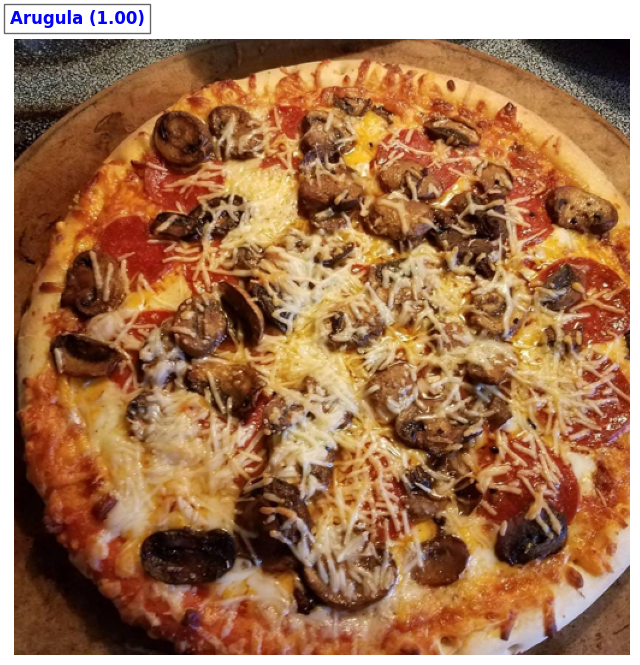

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step

--- Predictions for image 2 (/kaggle/input/pizza-toppings-object-detection/Pizza Object Detector.v7i.yolov8/valid/images/00038_jpg.rf.4654aa2ed5f73b28e5c0708269387afd.jpg) ---
Box 8:
  Coordinates: [-2.5334744 -7.2560143 -1.4019428 -4.436564 ]
  Label: Arugula
  Confidence: 1.00


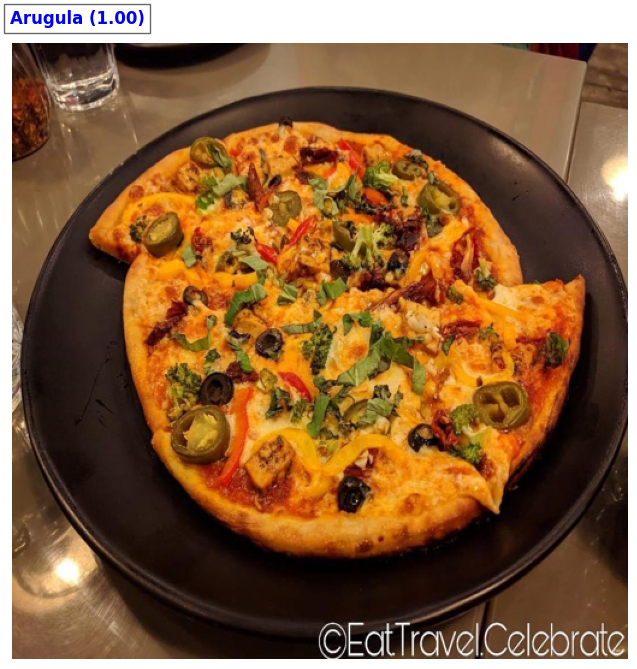

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step

--- Predictions for image 3 (/kaggle/input/pizza-toppings-object-detection/Pizza Object Detector.v7i.yolov8/valid/images/01301_jpg.rf.c238586973a37114fbcf9c029cd5a75b.jpg) ---
Box 8:
  Coordinates: [-1.4553379 -6.7691293  1.050526  -4.164374 ]
  Label: Arugula
  Confidence: 1.00


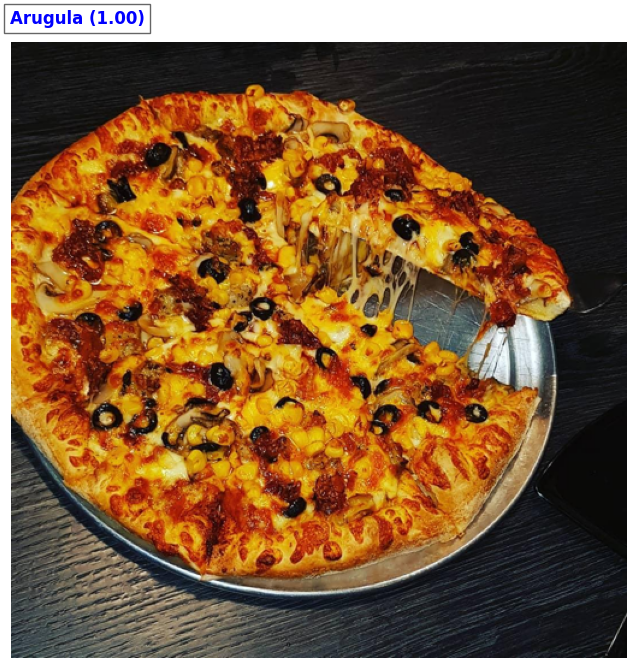

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step

--- Predictions for image 4 (/kaggle/input/pizza-toppings-object-detection/Pizza Object Detector.v7i.yolov8/valid/images/01287_jpg.rf.317befb3a5e290ca9f8c2e842f1850fc.jpg) ---
Box 8:
  Coordinates: [ 2.6163363  -0.64643335  1.5306286   1.6803566 ]
  Label: Arugula
  Confidence: 1.00


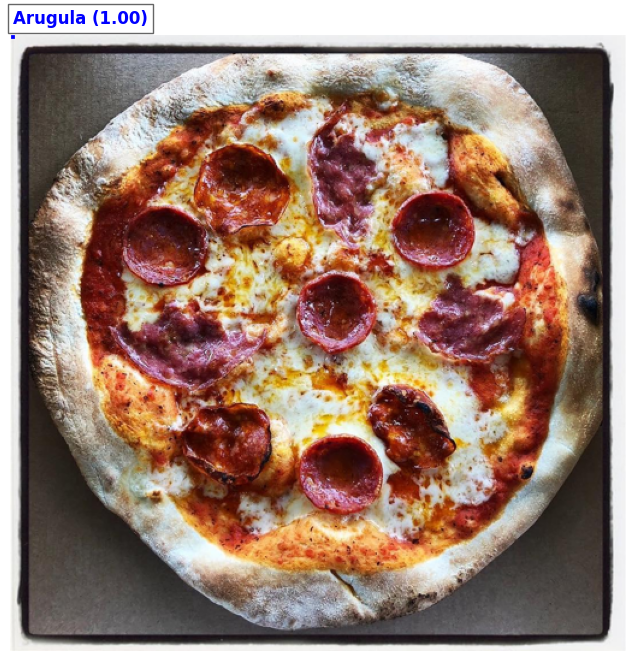

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step

--- Predictions for image 5 (/kaggle/input/pizza-toppings-object-detection/Pizza Object Detector.v7i.yolov8/valid/images/05838_jpg.rf.c7dc1923481f9f84b0afa4ce0496db5e.jpg) ---
Box 8:
  Coordinates: [-4.5072083 -4.531504   2.6178782 -7.7094827]
  Label: Arugula
  Confidence: 1.00


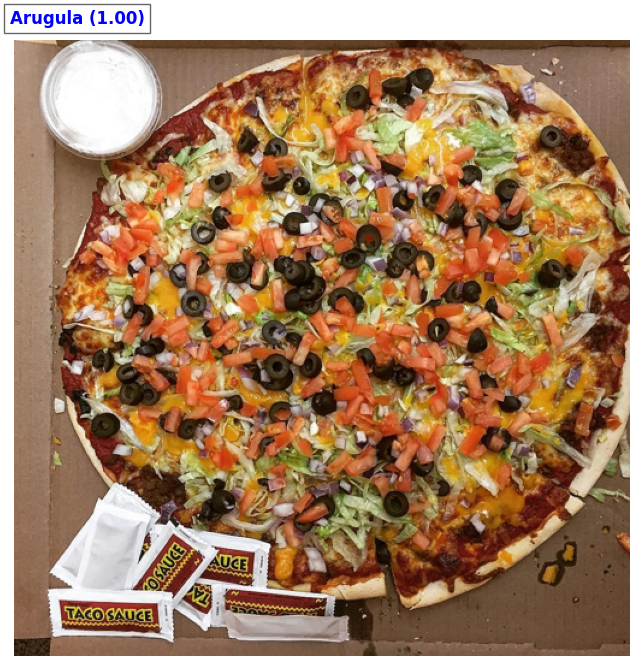

In [19]:
import random

def predict_and_plot(model, image_paths, label_colors, target_size=(224, 224), verbose=True):
    """
    Predicts bounding boxes and labels for a set of images using the trained model, 
    and plots the images with predicted bounding boxes and labels.

    Args:
        model (Model): The trained Keras model for bounding box and label prediction.
        image_paths (list): List of paths to the test images.
        label_colors (dict): Dictionary of colors for each label for visualization.
        target_size (tuple): Target size to resize each image (default is (224, 224)).
        verbose (bool): If True, print prediction details (box coordinates, labels, etc.).
    """
    for img_idx, path in enumerate(image_paths):
        # Load and preprocess the image
        img = Image.open(path)
        img_resized = img.resize(target_size)
        img_array = np.array(img_resized) / 255.0  # Normalize pixel values
        
        # Predict bounding boxes and class labels
        bbox_preds, class_preds = model.predict(np.expand_dims(img_array, axis=0))
        
        if verbose:
            print(f"\n--- Predictions for image {img_idx + 1} ({path}) ---")
        
        # Prepare the figure for plotting
        fig, ax = plt.subplots(1, figsize=(8, 8))
        ax.imshow(img_resized)
        
        # Loop through each predicted bounding box and class
        for box_idx, (bbox_pred, class_pred) in enumerate(zip(bbox_preds[0], class_preds[0])):
            # Get confidence score and label
            confidence = np.max(class_pred)
            class_idx = np.argmax(class_pred)
            class_label = LABELS[class_idx]
            
            # Ignore low-confidence predictions
            if confidence < 0.5:
                continue
            
            # Print details if verbose
            if verbose:
                print(f"Box {box_idx}:")
                print(f"  Coordinates: {bbox_pred}")
                print(f"  Label: {class_label}")
                print(f"  Confidence: {confidence:.2f}")
            
            # Convert bounding box to integer coordinates
            x1, y1, x2, y2 = map(int, bbox_pred)
            
            # Draw bounding box
            rect = patches.Rectangle((x1, y1), x2 - x1, y2 - y1, linewidth=2, 
                                      edgecolor=label_colors[class_label], facecolor='none')
            ax.add_patch(rect)

            # Draw label with confidence score
            ax.text(x1, y1 - 10, f"{class_label} ({confidence:.2f})", color=label_colors[class_label], 
                    fontsize=12, weight='bold', bbox=dict(facecolor='white', alpha=0.6))

        plt.axis('off')
        plt.show()


DATA_PATH = "/kaggle/input/pizza-toppings-object-detection/Pizza Object Detector.v7i.yolov8"
image_path = os.path.join(DATA_PATH, "valid/images")
print(f"image_paths: {image_paths}")

# List all pictures
all_image_paths = [os.path.join(image_path, fname) for fname in os.listdir(image_path)]

if len(all_image_paths) < 5:
    print("Pas assez d'images dans le dossier pour la sélection.")
else:
    test_image_paths = random.sample(all_image_paths, 5)  # 5 random images
    print(f"Selected test images: {test_image_paths}")
    
label_colors = {
    'Arugula': 'blue', 'Bacon': 'red', 'Basil': 'yellow', 'Broccoli': 'purple', 
    'Cheese': 'cyan', 'Chicken': 'olive', 'Corn': 'magenta', 'Ham': 'teal', 
    'Mushroom': 'maroon', 'Olives': 'lime', 'Onion': 'grey', 'Pepperoni': 'navy', 
    'Peppers': 'black', 'Pizza': 'orange', 'Tomatoes': 'peach'
}

from tensorflow.keras.models import load_model
from tensorflow.keras.losses import MeanSquaredError

model_path = "/kaggle/working/trained_pizza_topping_model.h5"
# model = load_model(model_path, custom_objects={'mse': MeanSquaredError()})
# model.summary()

predict_and_plot(model, test_image_paths, label_colors, target_size=IMG_SIZE)